# Part of Speech Tagging

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from textblob import TextBlob
from textblob.taggers import PatternTagger

import spacy


%matplotlib inline

## Basic Part of Speech Tagging

### NLTK

In [2]:
# Make sure you have the supporting packages installed; especially the corpora
# nltk.download()

In [3]:
tokenized_sent = nltk.sent_tokenize("Please book my flight to California")
[nltk.pos_tag(nltk.word_tokenize(word)) for word in tokenized_sent]

[[('Please', 'NNP'),
  ('book', 'NN'),
  ('my', 'PRP$'),
  ('flight', 'NN'),
  ('to', 'TO'),
  ('California', 'NNP')]]

In [4]:
# NLTK Version
tokenized_sent = nltk.sent_tokenize("I read a very good book")
[nltk.pos_tag(nltk.word_tokenize(word)) for word in tokenized_sent]

[[('I', 'PRP'),
  ('read', 'VBP'),
  ('a', 'DT'),
  ('very', 'RB'),
  ('good', 'JJ'),
  ('book', 'NN')]]

### TextBlob

In [5]:
blob = TextBlob("Please book my flight to California", pos_tagger=PatternTagger())
blob.tags

[('Please', 'VB'),
 ('book', 'NN'),
 ('my', 'PRP$'),
 ('flight', 'NN'),
 ('to', 'TO'),
 ('California', 'NNP')]

In [6]:
blob = TextBlob("I read a very good book", pos_tagger=PatternTagger())
blob.tags

[('I', 'PRP'),
 ('read', 'VB'),
 ('a', 'DT'),
 ('very', 'RB'),
 ('good', 'JJ'),
 ('book', 'NN')]

### Spacy

In [7]:
# Initialize spacy
nlp = spacy.load("en_core_web_sm")

In [8]:
# Spacy Version
doc = nlp("Please book my flight to California")
for token in doc:
    print(token.text, token.pos_)

Please INTJ
book VERB
my PRON
flight NOUN
to ADP
California PROPN


In [9]:
# Spacy Version
doc = nlp("I read a very good book")
for token in doc:
    print(token.text, token.pos_)

I PRON
read VERB
a DET
very ADV
good ADJ
book NOUN


## Voice of Customer Research

https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/activity

In [10]:
df = pd.read_csv("ClothingReviews.csv")
df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,Blouses


In [11]:
df.dropna(subset=['Review Text'], inplace=True)

### POS Tagging

In [12]:
def pos_tag(text):
    
    df = pd.DataFrame(columns = ['WORD', 'POS'])
    
    doc = nlp(text)
    for token in doc:
        df = df.append({'WORD': token.text, 'POS': token.pos_}, ignore_index=True)
        
    return df

In [13]:
# Take a random sample of reviews (5,000)
df2 = df.sample(5000, random_state=42).copy()
# Create an empty dataframe to store the results
df_pos = pd.DataFrame(columns = ['WORD', 'POS'])
# Iterate through the reviews and append each POS tag to the dataframe
df_pos = pos_tag(df2['Review Text'].to_string())
df_pos.shape

(72202, 2)

In [14]:
# Get rid of some of the uninteresting POS tags
df_pos = df_pos[(df_pos['POS'] != 'SPACE') & (df_pos['POS'] != 'PUNCT') & (df_pos['POS'] != 'NUM')]

In [15]:
df_top_pos = df_pos.groupby('POS')['POS'].count().\
    reset_index(name='count').sort_values(['count'],ascending=False).head(15)

In [16]:
df_top_pos

,POS,count
7,NOUN,9017
9,PRON,6856
5,DET,5950
13,VERB,5626
0,ADJ,4835
3,AUX,3567
1,ADP,3412
2,ADV,2915
4,CCONJ,2012
10,PROPN,1348


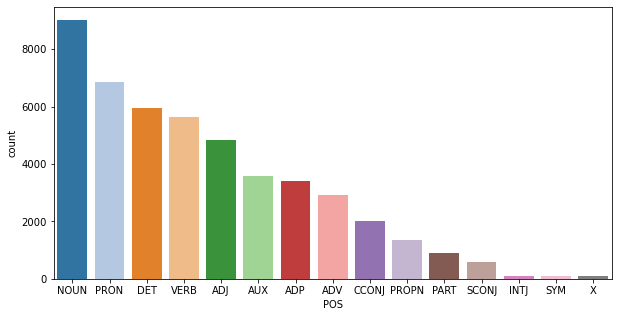

In [17]:
plt.figure(figsize=(10,5))
sns.barplot(data =df_top_pos, x='POS', y='count', palette="tab20");

#### Identify Top Product Nouns

In [19]:
df_nn = df_pos[df_pos['POS'] == 'NOUN'].copy()
df_nn.groupby('WORD')['WORD'].count().reset_index(name='count').\
    sort_values(['count'], ascending=False).head(10)

,WORD,count
455,dress,938
1417,top,603
1204,shirt,245
1348,sweater,222
313,color,191
1309,store,149
1238,size,143
521,fabric,138
1247,skirt,130
964,pants,119


In [20]:
df_adj = df_pos[df_pos['POS'] == 'ADJ'].copy()
df_adj.groupby('WORD')['WORD'].count().reset_index(name='count').\
    sort_values(['count'], ascending=False).head(10)

,WORD,count
281,great,256
95,beautiful,199
168,cute,192
554,soft,160
146,comfortable,136
445,perfect,128
548,small,89
409,nice,78
34,Great,76
428,other,75


## Noun Phrase Chunking

In [21]:
def np_tag(text):
    
    df = pd.DataFrame(columns = ['CHUNK'])
    
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        df = df.append({'CHUNK': chunk.text}, ignore_index=True)
        
    return df

In [22]:
# Convert our reviews to lowercase to simplify our search
df["Review Text"] = df["Review Text"].str.lower()

# Find only reviews that have the word 'dress' in them
filter = df['Review Text'].str.contains('dress')
df_dress = df[filter].copy()
df_dress.shape

(7022, 8)

In [23]:
# Create an empty dataframe to store the results
df_np = pd.DataFrame(columns = ['CHUNK'])

# Iterate through the reviews and append each POS tag to the dataframe
df_np = np_tag(df_dress['Review Text'].to_string())
df_np.shape

(20825, 1)

In [24]:
# Show the top 10 noun phrases - notice that there are a lot of filler words (stop words)
df_np.groupby('CHUNK')['CHUNK'].count().\
    reset_index(name='count').sort_values(['count'],ascending=False).head(10)

,CHUNK,count
2238,i,5054
4476,this dress,2878
2262,it,1480
4417,this,948
3609,the dress,207
4660,this top,158
2374,love,144
2426,me,140
4959,you,134
3377,that,125


In [25]:
# As opposed to removing stop words, we can filter out rows in the dataframe
# that have the stop words.  This is a better way for noun phrases since we won't lose
# the context of the phrases during our prior extraction. 
filter = (df_np['CHUNK'].str.contains('this')) | \
         (df_np['CHUNK'].str.contains('the')) | \
         (df_np['CHUNK'].str.contains('that')) | \
         (df_np['CHUNK'].str.contains('my')) | \
         (df_np['CHUNK'].str.contains('a')) | \
         (df_np['CHUNK'].str.len() < 6)
df_np = df_np[-filter]

In [26]:
# Filter for words with spaces, so that we get only phrases with more than one word.
filter = (df_np['CHUNK'].str.contains(' '))
df_np = df_np[filter]

In [27]:
df_np.groupby('CHUNK')['CHUNK'].count().\
    reset_index(name='count').sort_values(['count'],ascending=False).head(10)

,CHUNK,count
330,full price,12
287,both colors,12
343,high hopes,7
580,very pretty dress,6
123,135 lbs,5
323,first sight,5
533,those dresses,4
427,one size,4
436,our store,3
243,4 dress,3
